In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
data = "../input/3d-object-detection-for-autonomous-vehicles"

In [4]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

In [5]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) 
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', 
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

In [6]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

In [7]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w 
            y = (row + y) / grid_h 
            w = anchors[2 * b + 0] * np.exp(w) / net_w 
            h = anchors[2 * b + 1] * np.exp(h) / net_h 
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
def load_image_pixels(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    return image, width, height
 
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
                if box.classes[i] > thresh:
                    v_boxes.append(box)
                    v_labels.append(labels[i])
                    v_scores.append(box.classes[i]*100)
    return v_boxes, v_labels, v_scores
 
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    pyplot.show()

In [8]:
model = make_yolov3_model()
weight_reader = WeightReader('../input/lyft-3d-recognition/yolov3.weights')
weight_reader.load_weights(model)
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [9]:
from keras.models import load_model
model = load_model('model.h5')

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
______________________________________________________________________________________________

In [10]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
WIDTH, HEIGHT = 416, 416
class_threshold = 0.3

In [11]:
import os
from matplotlib import pyplot as plt
images = os.listdir('../input/3d-object-detection-for-autonomous-vehicles/train_images')[:100]
#len(images) for whole dataset = 158757

In [12]:
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array
def load_image_pixels(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    return image, width, height

In [13]:
scores_final = {"person":0, "bicycle":0, "car":0, "motorbike":0, "aeroplane":0, "bus":0, "train":0, "truck":0,"boat":0}
counter_final = {"person":0, "bicycle":0, "car":0, "motorbike":0, "aeroplane":0, "bus":0, "train":0, "truck":0,"boat":0}
    
for file in images:
    photo_filename = data + '/train_images/' + file
    image, image_w, image_h = load_image_pixels(photo_filename, (WIDTH, HEIGHT))
    yhat = model.predict(image)
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], .8, HEIGHT, WIDTH)
    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)
    do_nms(boxes, 0.5)
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat"]
    #v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, 0.8)
    #for i in range(len(v_boxes)):
    #    print(v_labels[i], v_scores[i])
        
    
    for i in range(len(v_boxes)):
        scores_final[v_labels[i]]+=v_scores[i]
        counter_final[v_labels[i]]+=1
    
    
        
print(scores_final)
print(counter_final)   
    #draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

{'person': 553.237771987915, 'bicycle': 97.16315865516663, 'car': 28140.483063459396, 'motorbike': 97.88905382156372, 'aeroplane': 0, 'bus': 366.3463532924652, 'train': 178.33844423294067, 'truck': 813.2881045341492, 'boat': 0}
{'person': 6, 'bicycle': 1, 'car': 303, 'motorbike': 1, 'aeroplane': 0, 'bus': 4, 'train': 2, 'truck': 9, 'boat': 0}


In [14]:
#conf score calc

for i in labels:
    if(counter_final[i]!=0):
        print("conf score of"+str(i)+":"+str(scores_final[i]/counter_final[i]))
    else:
        print("Conf score can't be displayed due to lack of samples of "+str(i))

conf score ofperson:92.20629533131917
conf score ofbicycle:97.16315865516663
conf score ofcar:92.87288139755576
conf score ofmotorbike:97.88905382156372
Conf score can't be displayed due to lack of samples of aeroplane
conf score ofbus:91.5865883231163
conf score oftrain:89.16922211647034
conf score oftruck:90.3653449482388
Conf score can't be displayed due to lack of samples of boat


truck 94.47240233421326
car 95.99141478538513
car 96.51923775672913
car 98.87382388114929


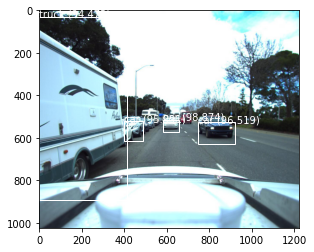

car 90.90201258659363
car 86.64723038673401


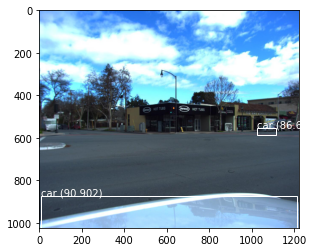

car 99.49303269386292
car 85.27180552482605
car 97.52064943313599
car 83.2088828086853


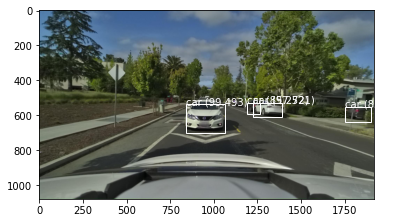

car 92.42860078811646
car 92.89239048957825


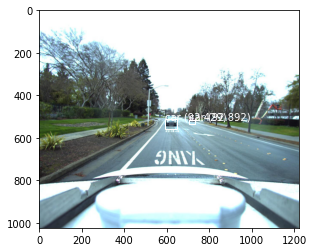

truck 90.99632501602173
car 98.18232655525208


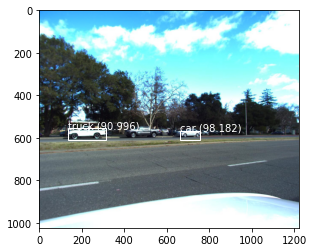

bus 92.19626784324646
car 88.9475405216217
car 87.45279908180237
car 80.00765442848206
car 99.15739893913269


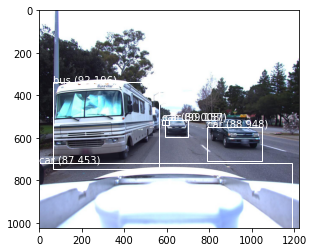

car 99.4914710521698
car 96.72788977622986
car 84.5885694026947
car 84.10609364509583
car 84.15658473968506


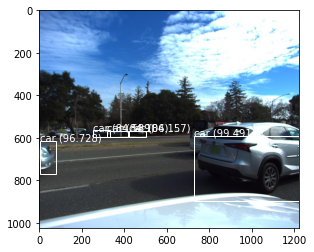

car 99.98246431350708
car 95.04622220993042
car 84.31439995765686
car 91.98101162910461
car 94.28300261497498
car 89.67056274414062


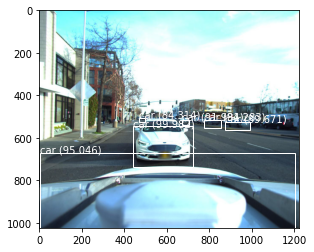

car 86.70346140861511
car 91.92036390304565
car 83.37287306785583
car 88.03302049636841
car 87.4018907546997
car 92.23202466964722


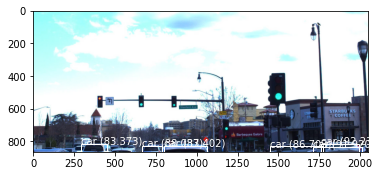

car 99.59219098091125
car 99.41357374191284
car 97.95092344284058


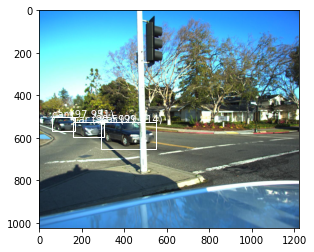

In [15]:
images = os.listdir('../input/3d-object-detection-for-autonomous-vehicles/train_images')[:10]
for file in images:
    photo_filename = data + '/train_images/' + file
    image, image_w, image_h = load_image_pixels(photo_filename, (WIDTH, HEIGHT))
    yhat = model.predict(image)
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], .8, HEIGHT, WIDTH)
    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)
    do_nms(boxes, 0.5)
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat"]
    #v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, 0.8)
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])
        
        
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [16]:
images = os.listdir('../input/3d-object-detection-for-autonomous-vehicles/train_images')[:100]

scores_final = {"person":0, "bicycle":0, "car":0, "motorbike":0, "aeroplane":0, "bus":0, "train":0, "truck":0,"boat":0}
counter_final = {"person":0, "bicycle":0, "car":0, "motorbike":0, "aeroplane":0, "bus":0, "train":0, "truck":0,"boat":0}
    
for file in images:
    photo_filename = data + '/train_images/' + file
    image, image_w, image_h = load_image_pixels(photo_filename, (WIDTH, HEIGHT))
    yhat = model.predict(image)
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], .75, HEIGHT, WIDTH)
    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)
    do_nms(boxes, 0.5)
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat"]
    #v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, 0.75)
    #for i in range(len(v_boxes)):
    #    print(v_labels[i], v_scores[i])
        
    
    for i in range(len(v_boxes)):
        scores_final[v_labels[i]]+=v_scores[i]
        counter_final[v_labels[i]]+=1
    
    
        
print(scores_final)
print(counter_final)   
    #draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

{'person': 553.237771987915, 'bicycle': 97.16315865516663, 'car': 30780.19260764122, 'motorbike': 97.88905382156372, 'aeroplane': 0, 'bus': 445.4340398311615, 'train': 178.33844423294067, 'truck': 888.9275968074799, 'boat': 0}
{'person': 6, 'bicycle': 1, 'car': 337, 'motorbike': 1, 'aeroplane': 0, 'bus': 5, 'train': 2, 'truck': 10, 'boat': 0}


In [17]:
#conf score calc

for i in labels:
    if(counter_final[i]!=0):
        print("conf score of"+str(i)+":"+str(scores_final[i]/counter_final[i]))
    else:
        print("Conf score can't be displayed due to lack of samples of "+str(i))

conf score ofperson:92.20629533131917
conf score ofbicycle:97.16315865516663
conf score ofcar:91.33588310872766
conf score ofmotorbike:97.88905382156372
Conf score can't be displayed due to lack of samples of aeroplane
conf score ofbus:89.0868079662323
conf score oftrain:89.16922211647034
conf score oftruck:88.89275968074799
Conf score can't be displayed due to lack of samples of boat


truck 94.47240233421326
car 95.99141478538513
car 96.51923775672913
car 98.87382388114929


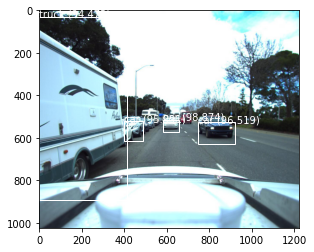

In [18]:
images = os.listdir('../input/3d-object-detection-for-autonomous-vehicles/train_images')[:1]
for file in images:
    photo_filename = data + '/train_images/' + file
    image, image_w, image_h = load_image_pixels(photo_filename, (WIDTH, HEIGHT))
    yhat = model.predict(image)
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], .8, HEIGHT, WIDTH)
    correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)
    do_nms(boxes, 0.3)
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck","boat"]
    #v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, 0.8)
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])
        
    
    
    
    
        

    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [19]:
import pandas as pd

train_df = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/train.csv')
train_df.head()

,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...


In [20]:
import pandas as pd

train_df = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/train.csv')
train_df['PredictionString'][0]

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778

In [21]:
import json
  
# Opening JSON file
f = open('../input/3d-object-detection-for-autonomous-vehicles/train_data/sample_data.json',)
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json
# list
print("printing data for one image")
print(data[:1][:])


  
# Closing file
f.close()

printing data for one image
[{'is_key_frame': True, 'prev': 'd190078ec7869ad5c9e5417371aa3b45eb1c22804a0a290ed4695042799b7470', 'fileformat': 'bin', 'token': 'ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696', 'timestamp': 1549920983701948.2, 'next': '8182fb6868baf63c245a4994b7f3034a7d281d1928a7844b7b7159cff3b91a1e', 'ego_pose_token': 'd90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeaebdcefbf4529209237f', 'sample_token': 'fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced363a2ebac41f465830d', 'filename': 'lidar/host-a007_lidar1_1233956183701948366.bin', 'calibrated_sensor_token': '3b463530b5bae9698c9cc803c1731c36abd359a7296e23e81f8c0b546f60e749'}]
